Using device: mps
Using device: mps
Using device: mps


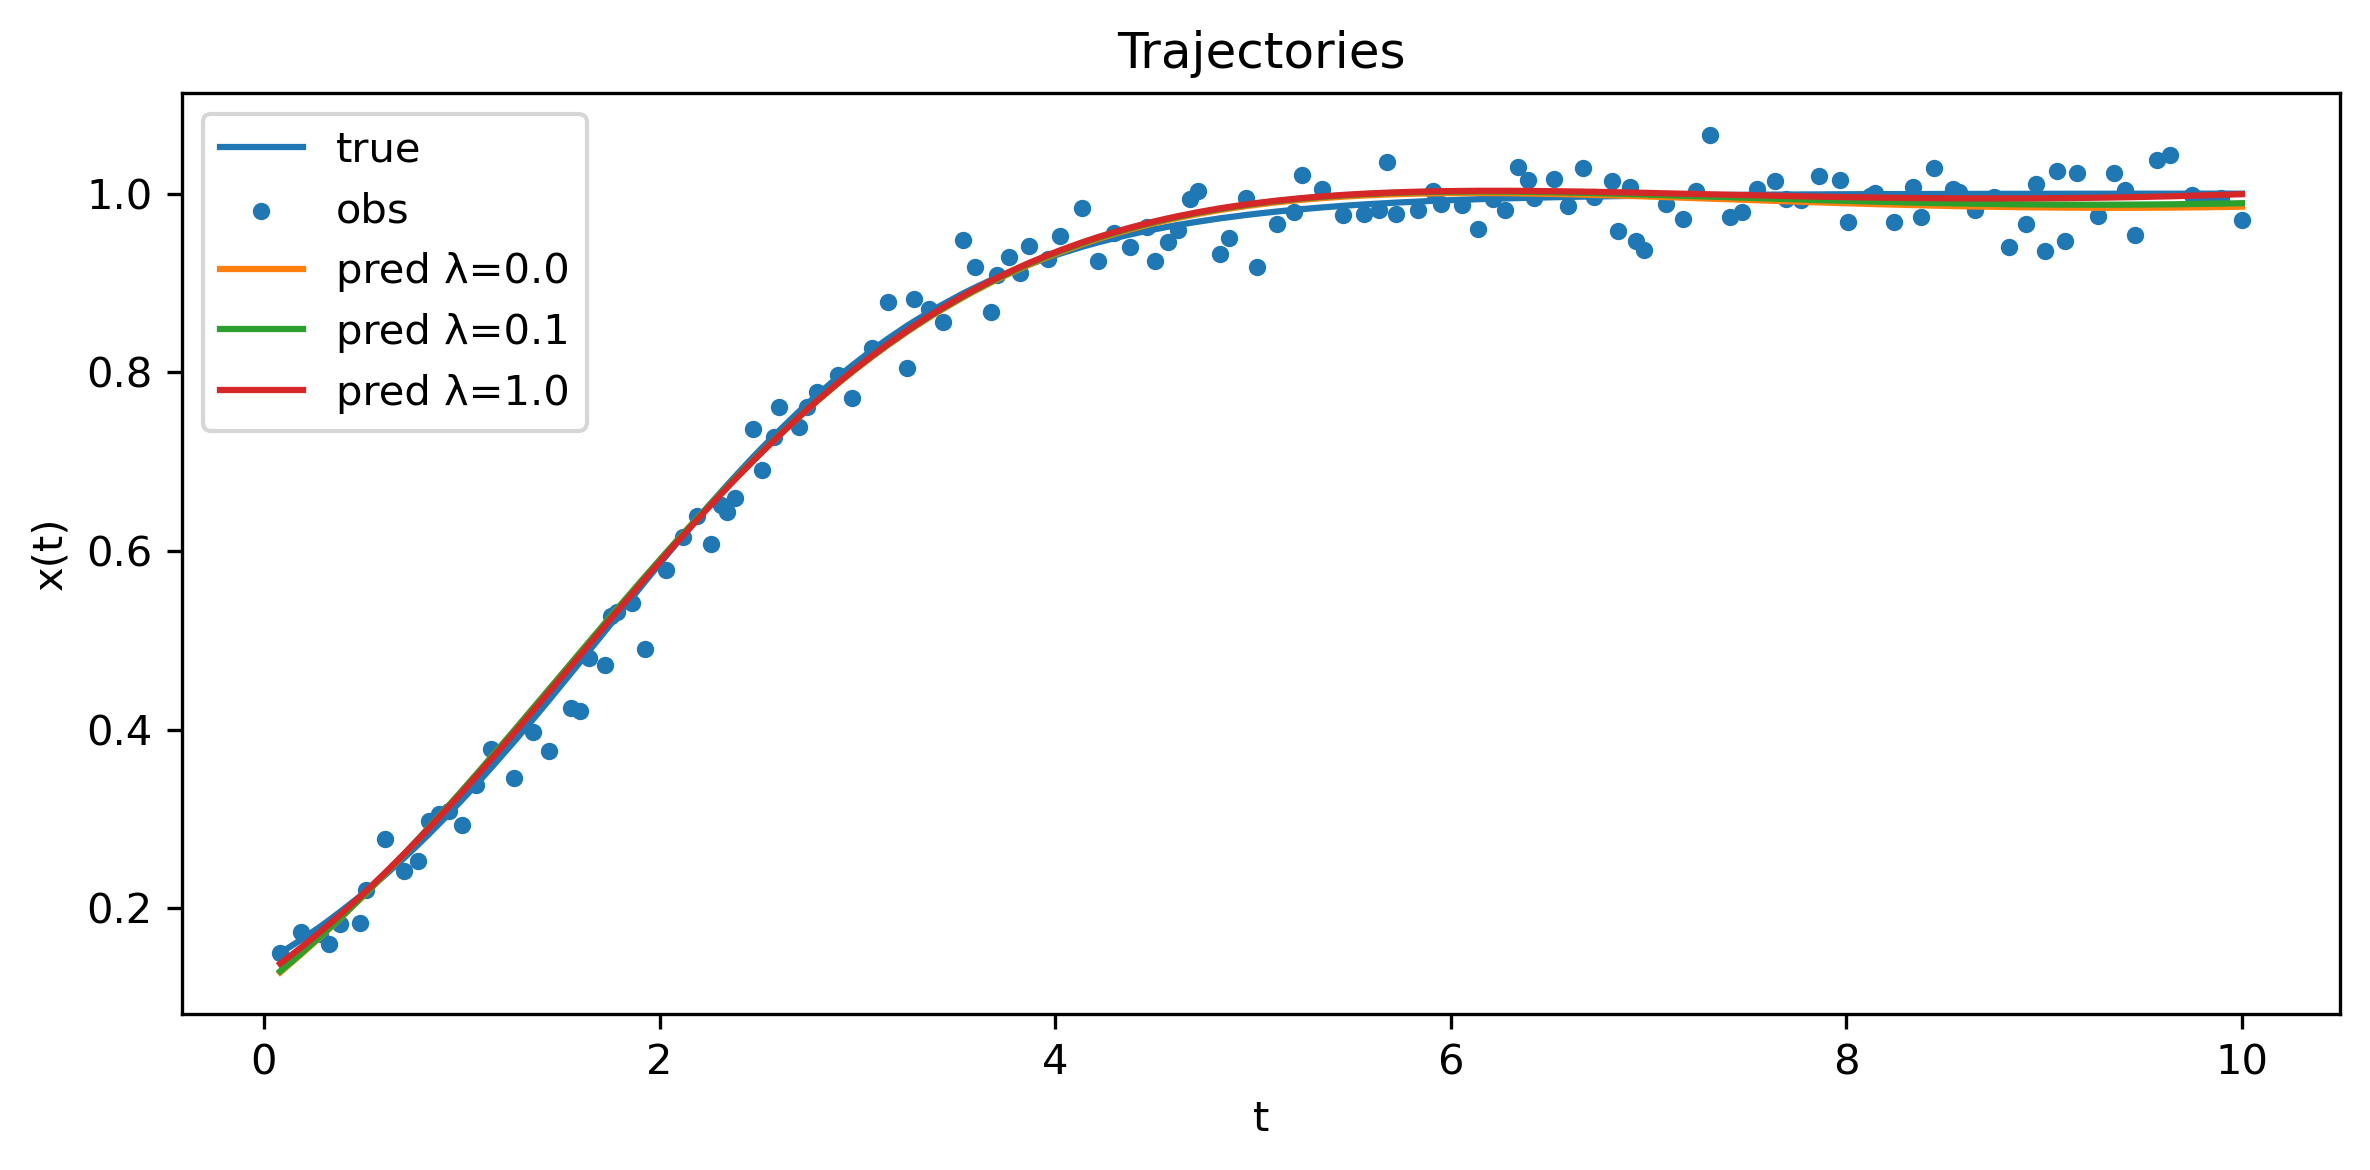

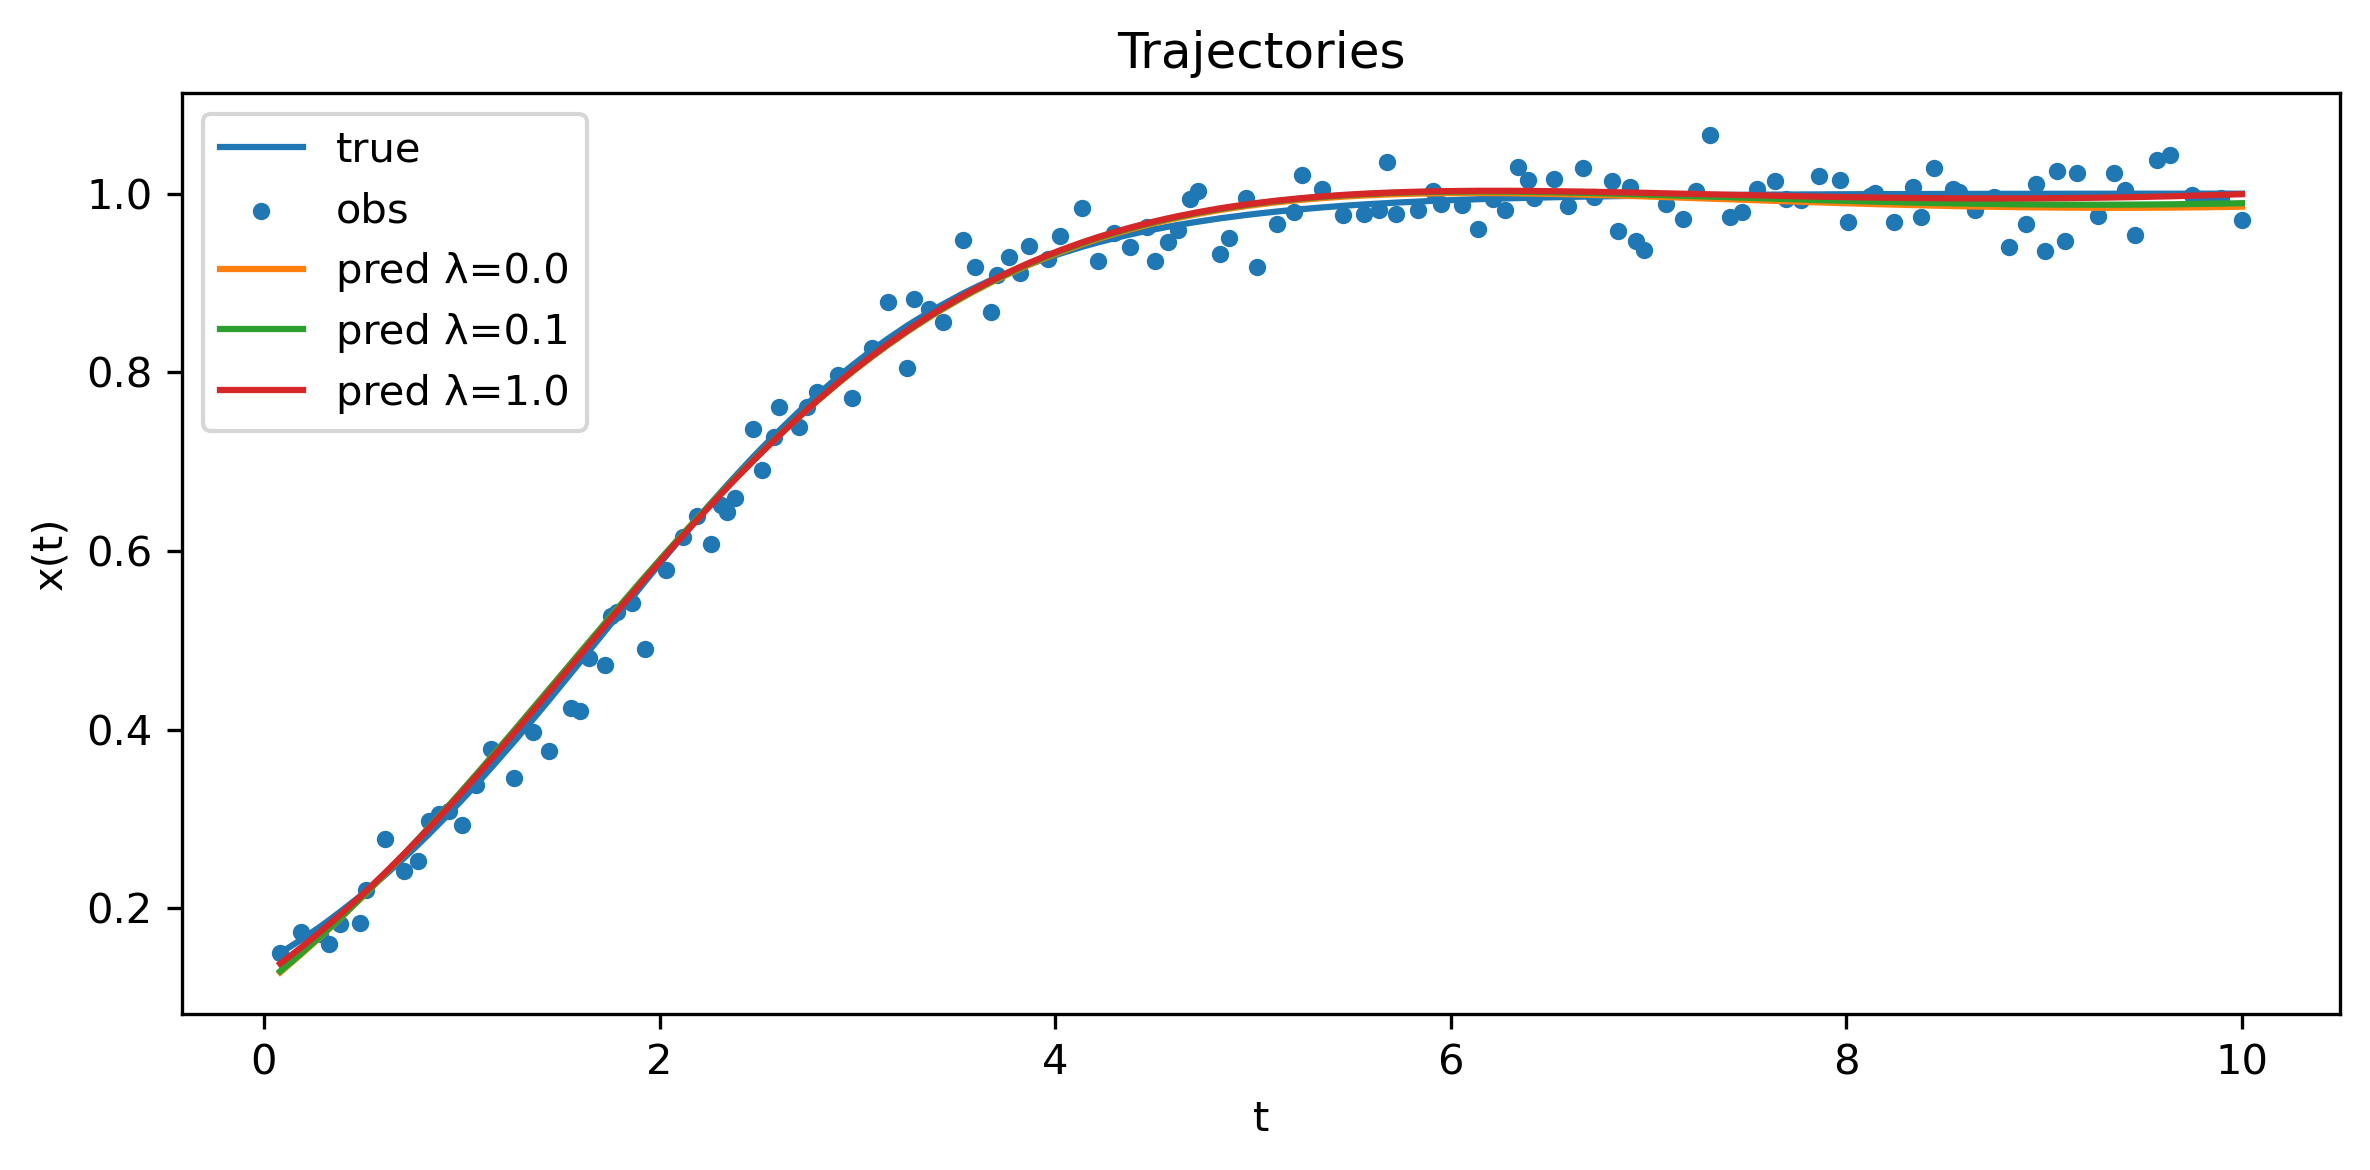

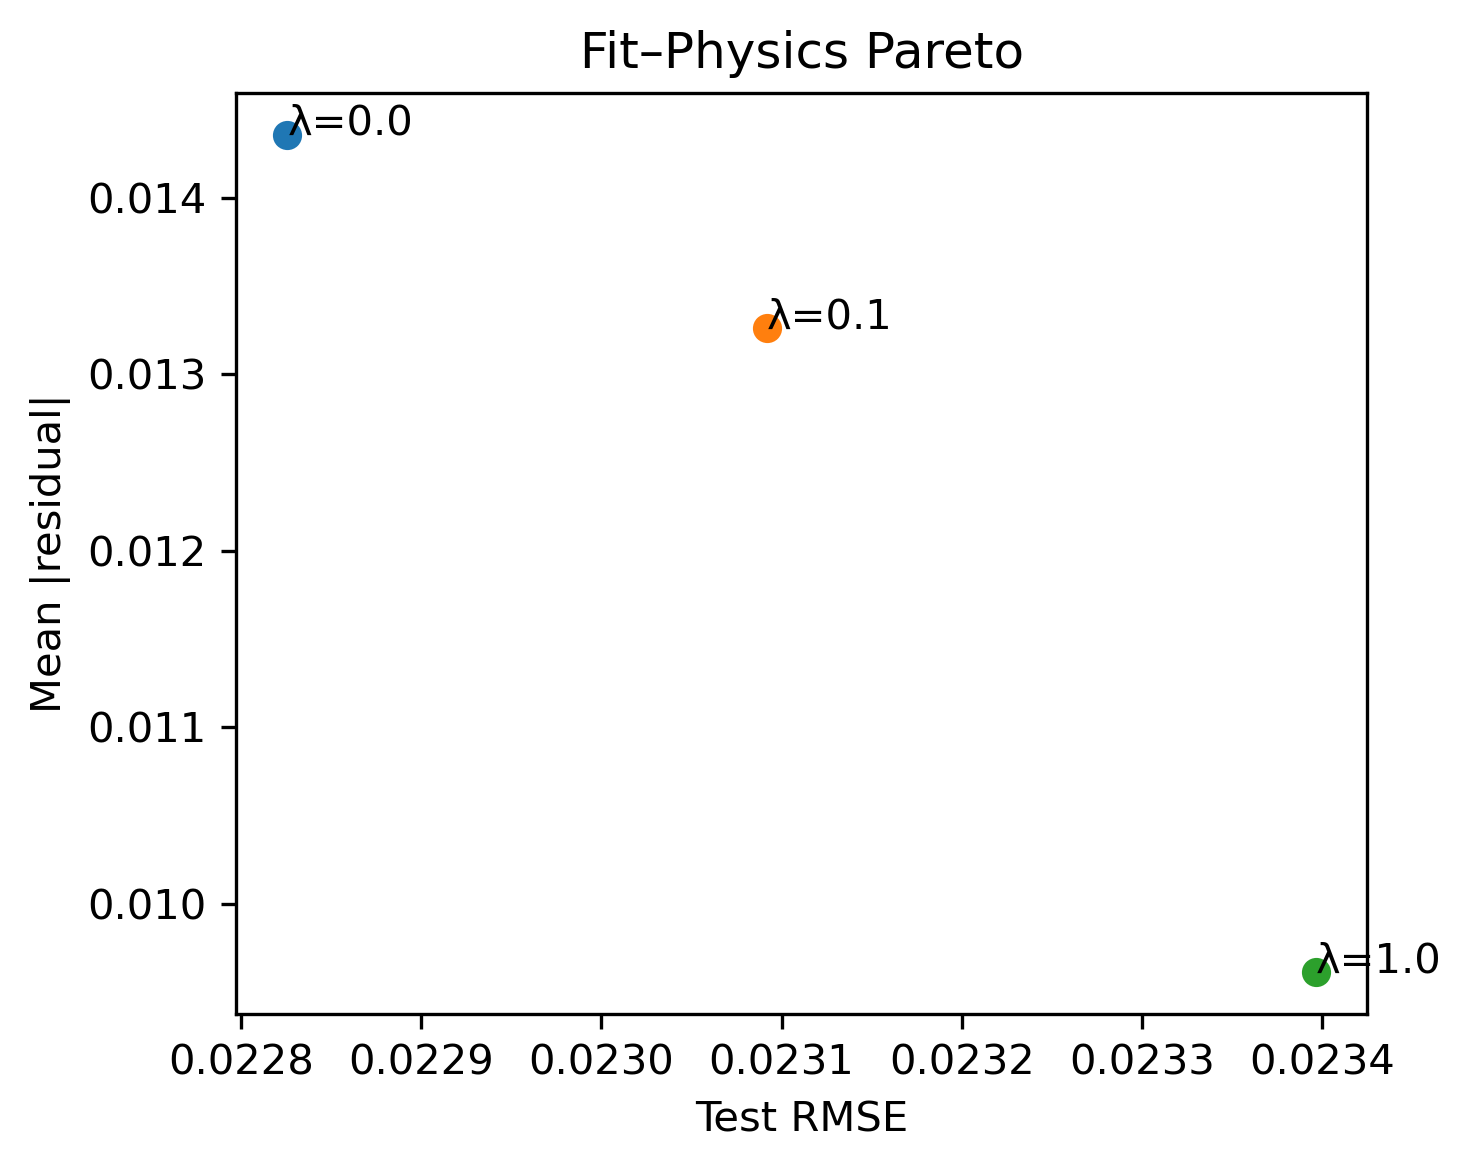

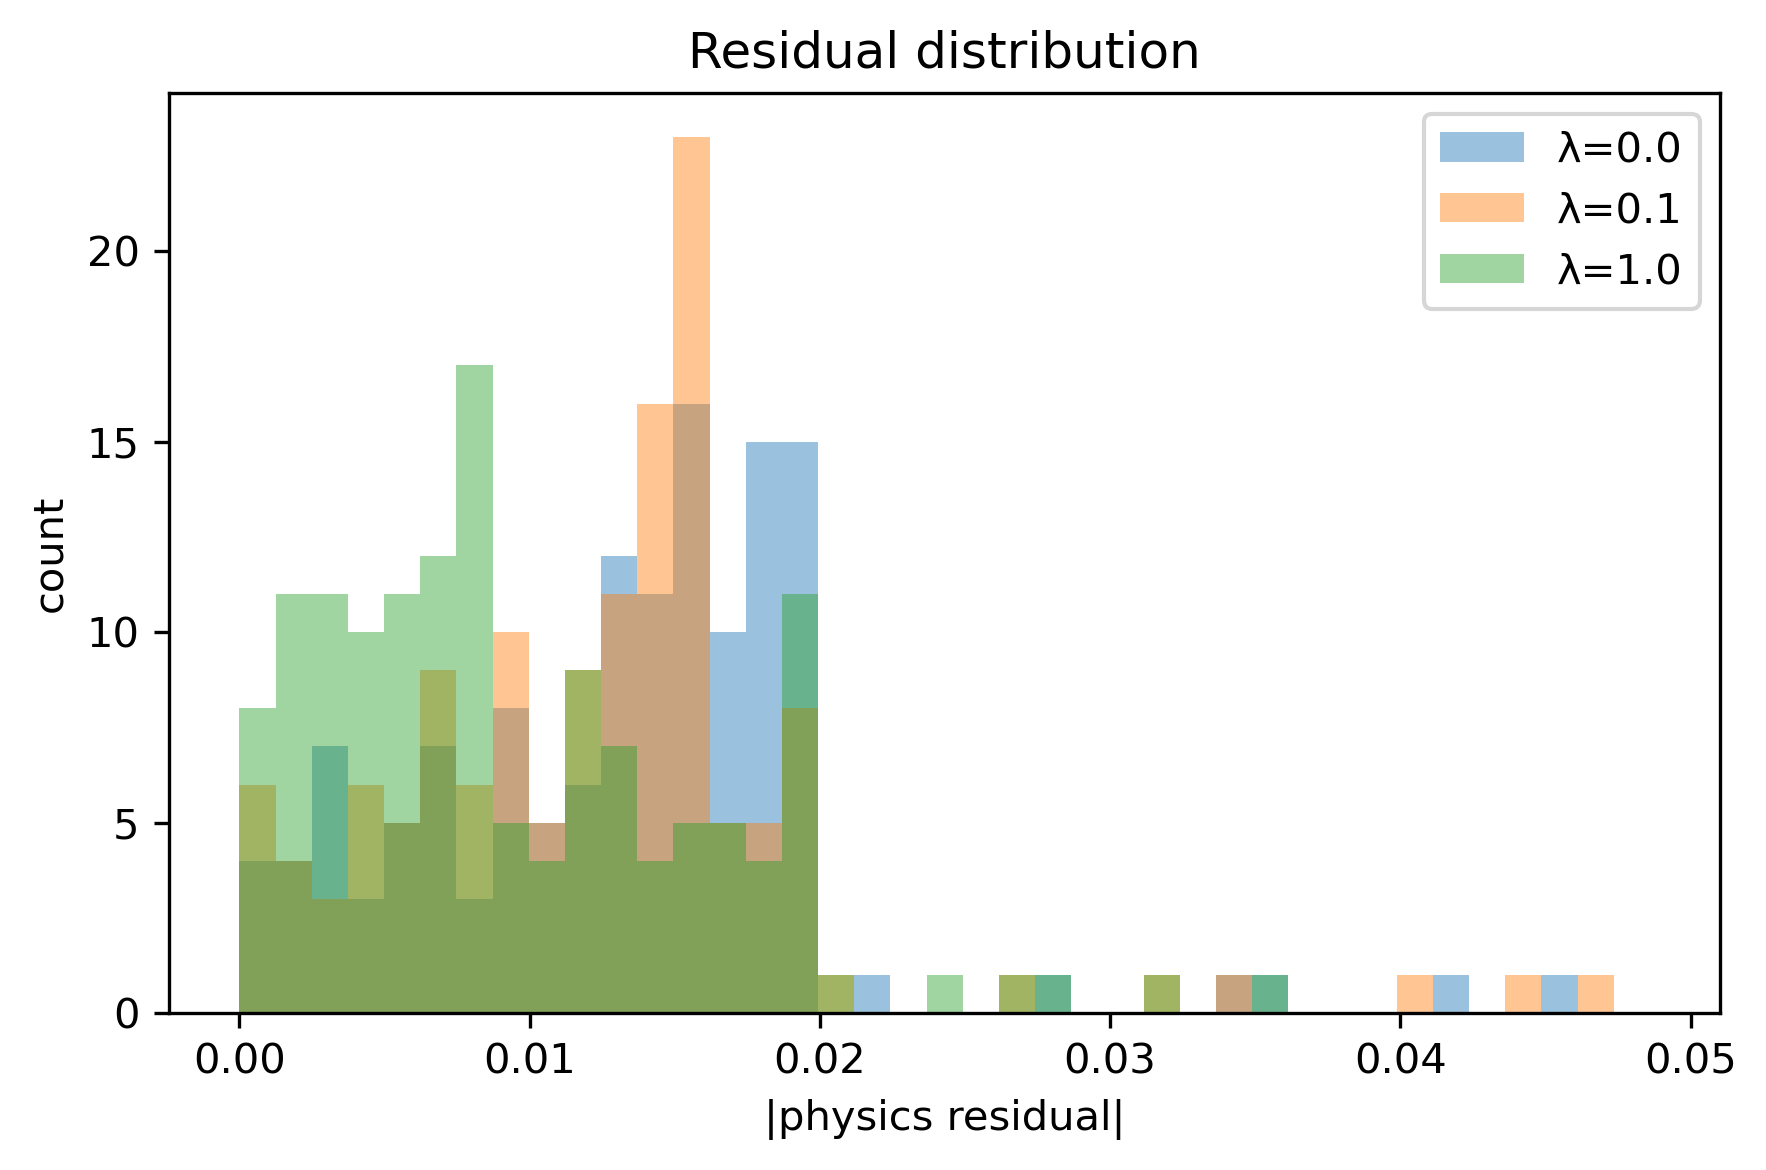

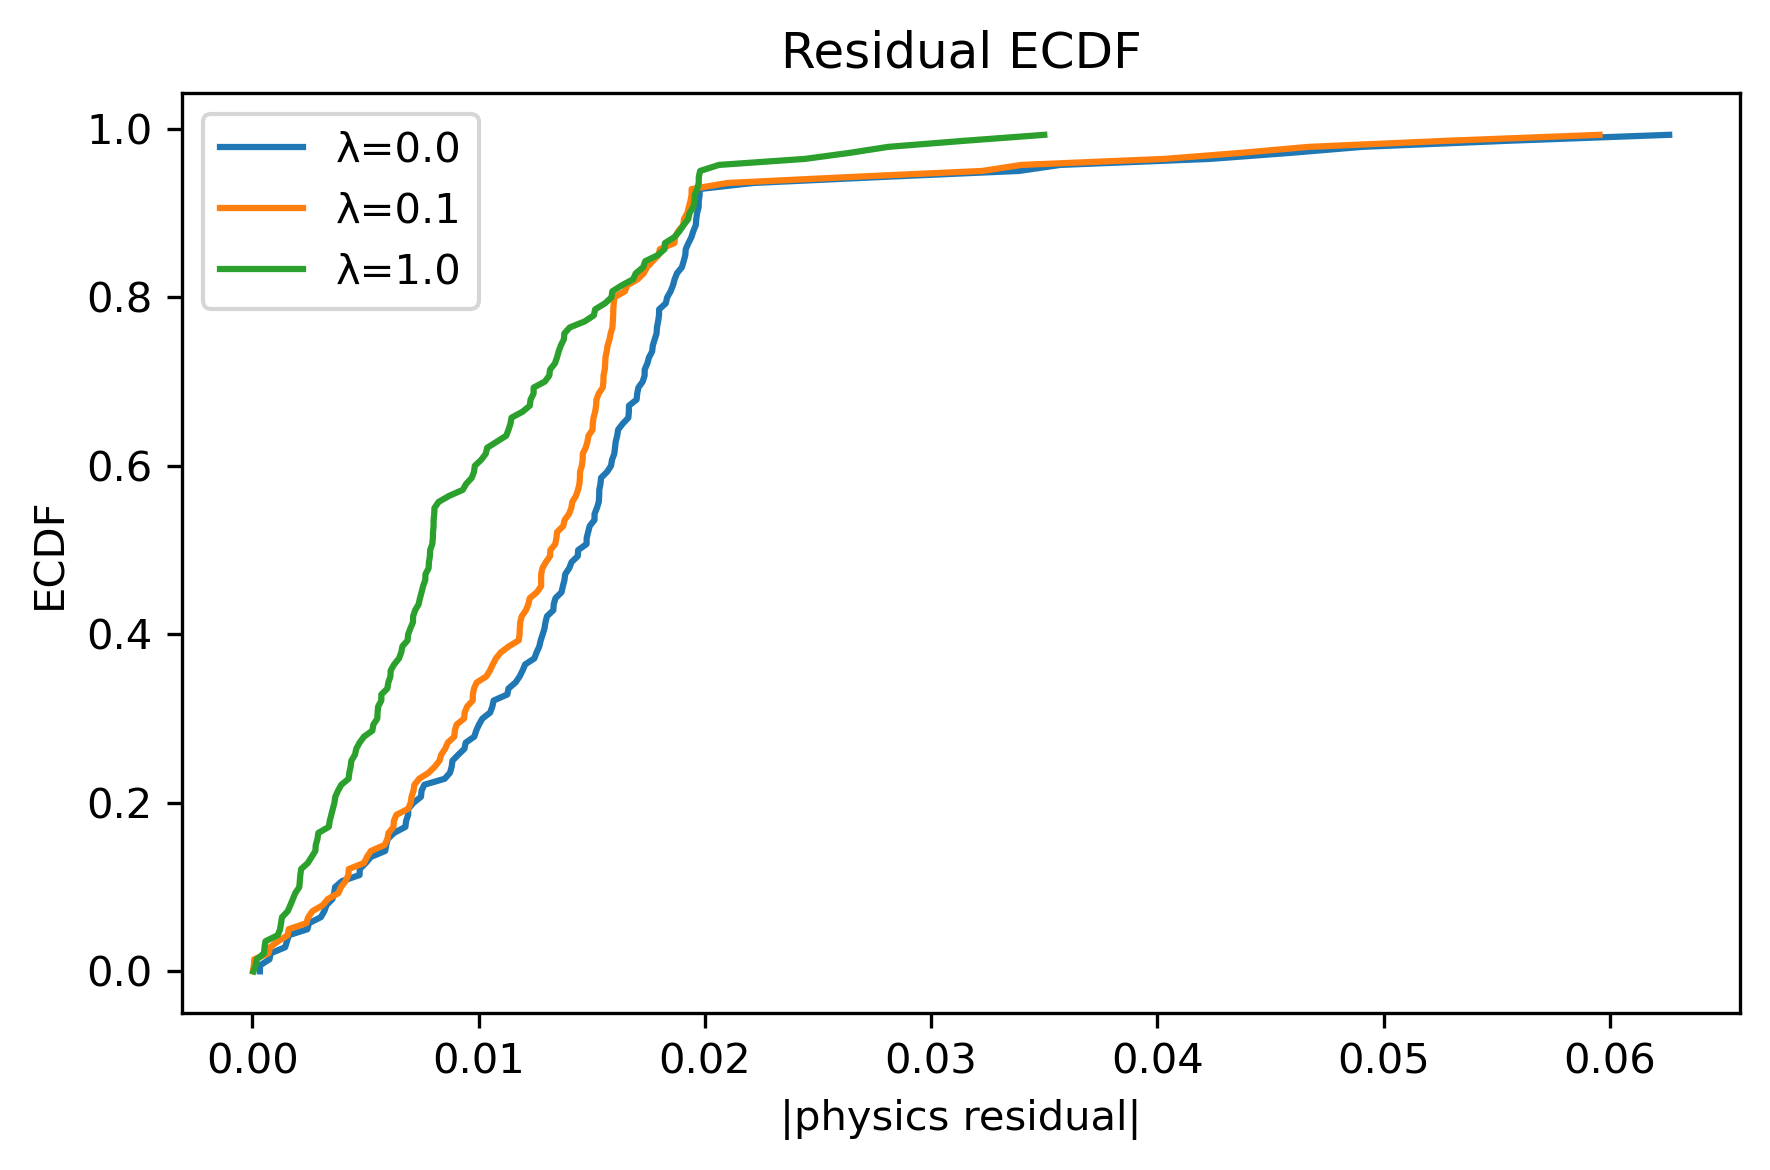

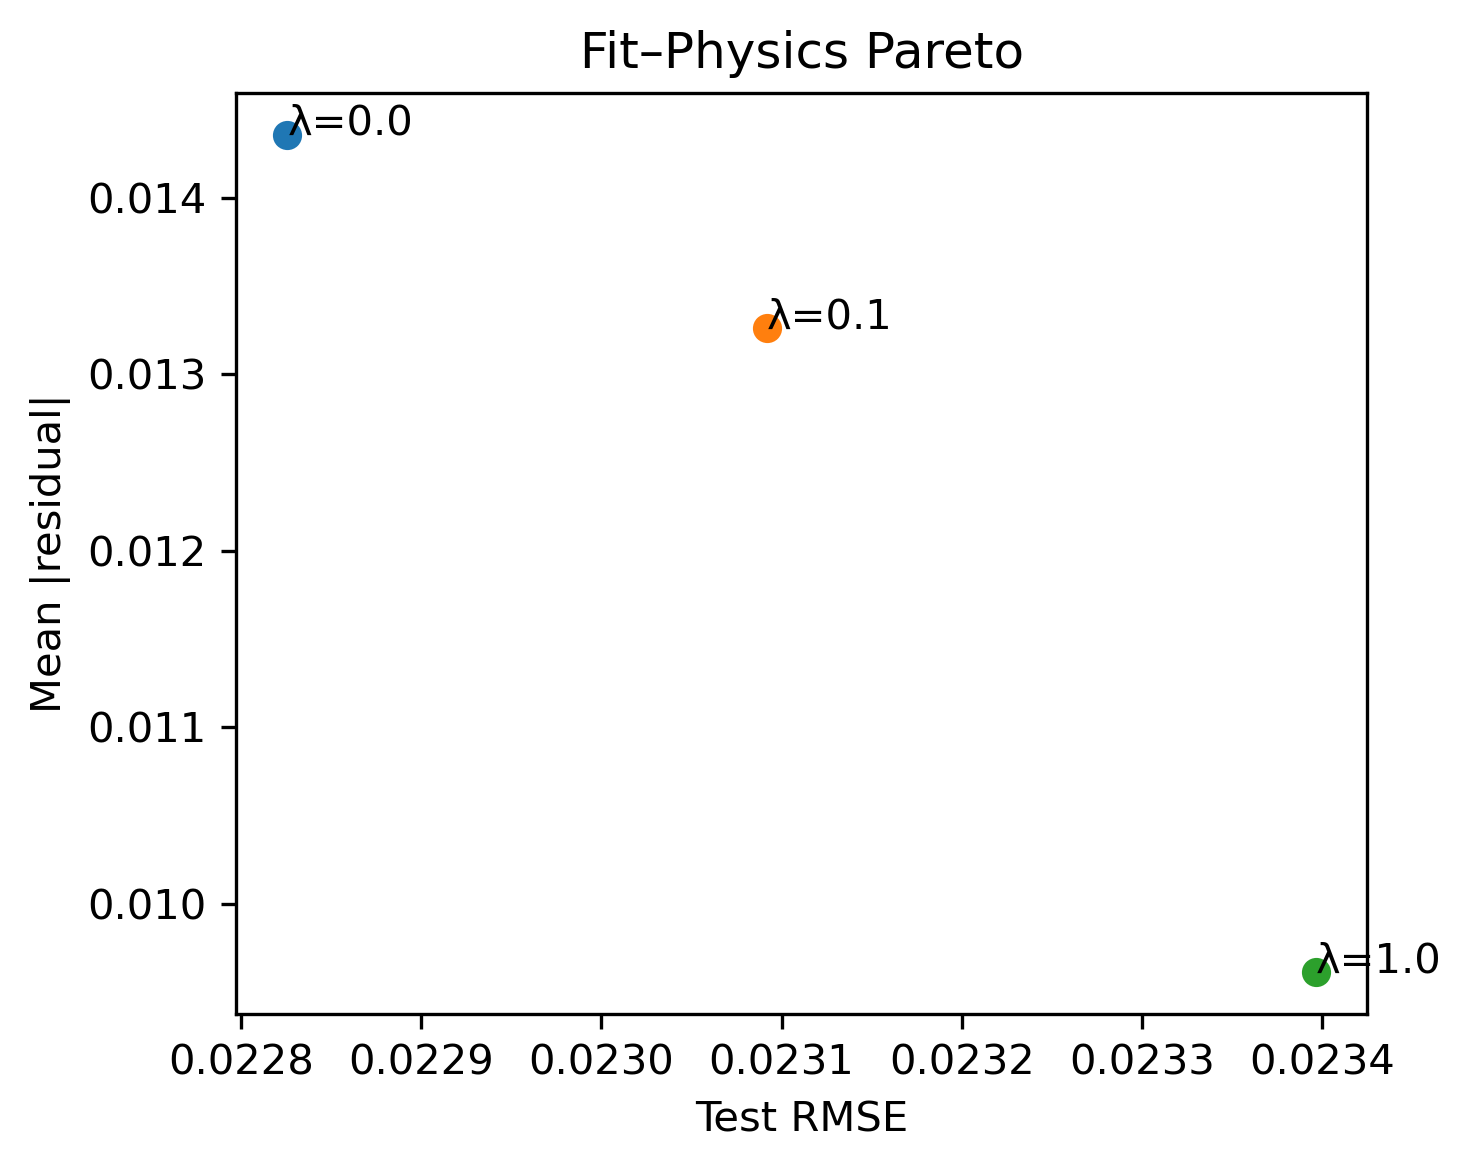

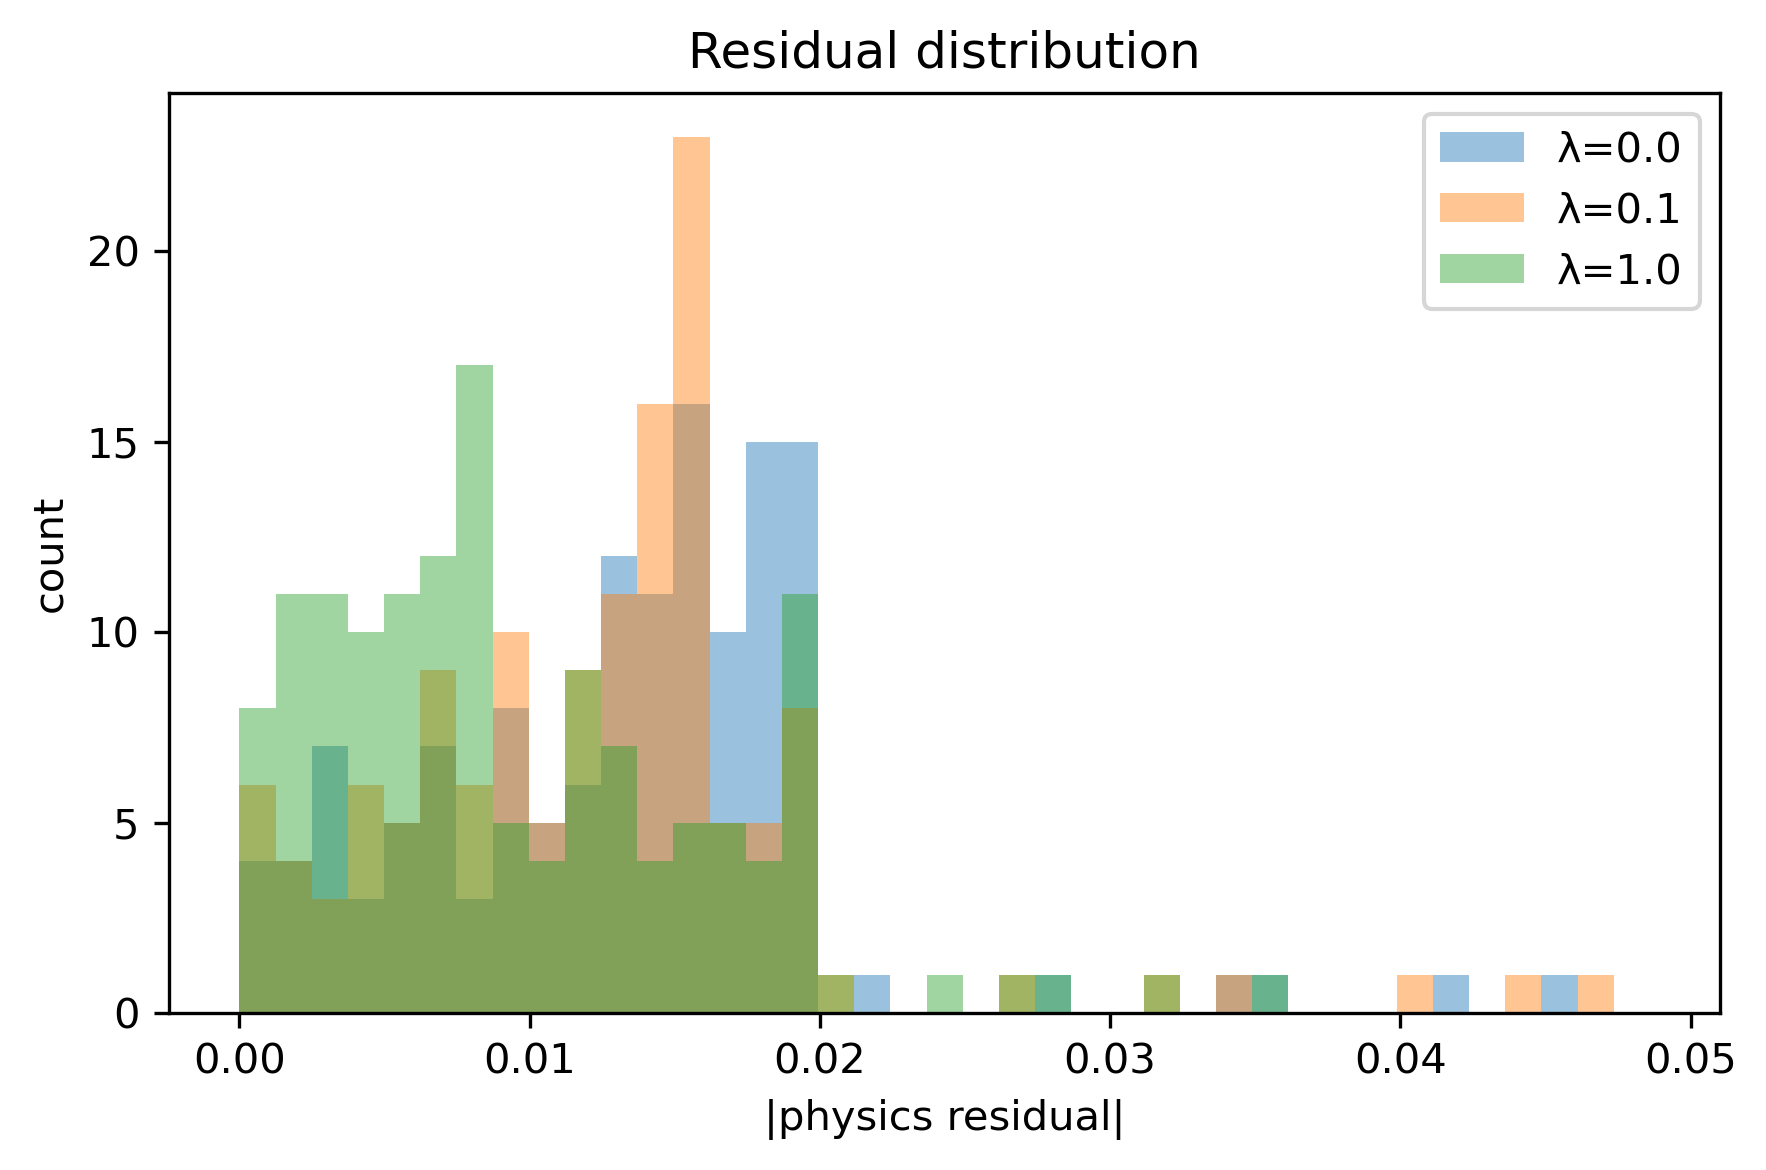

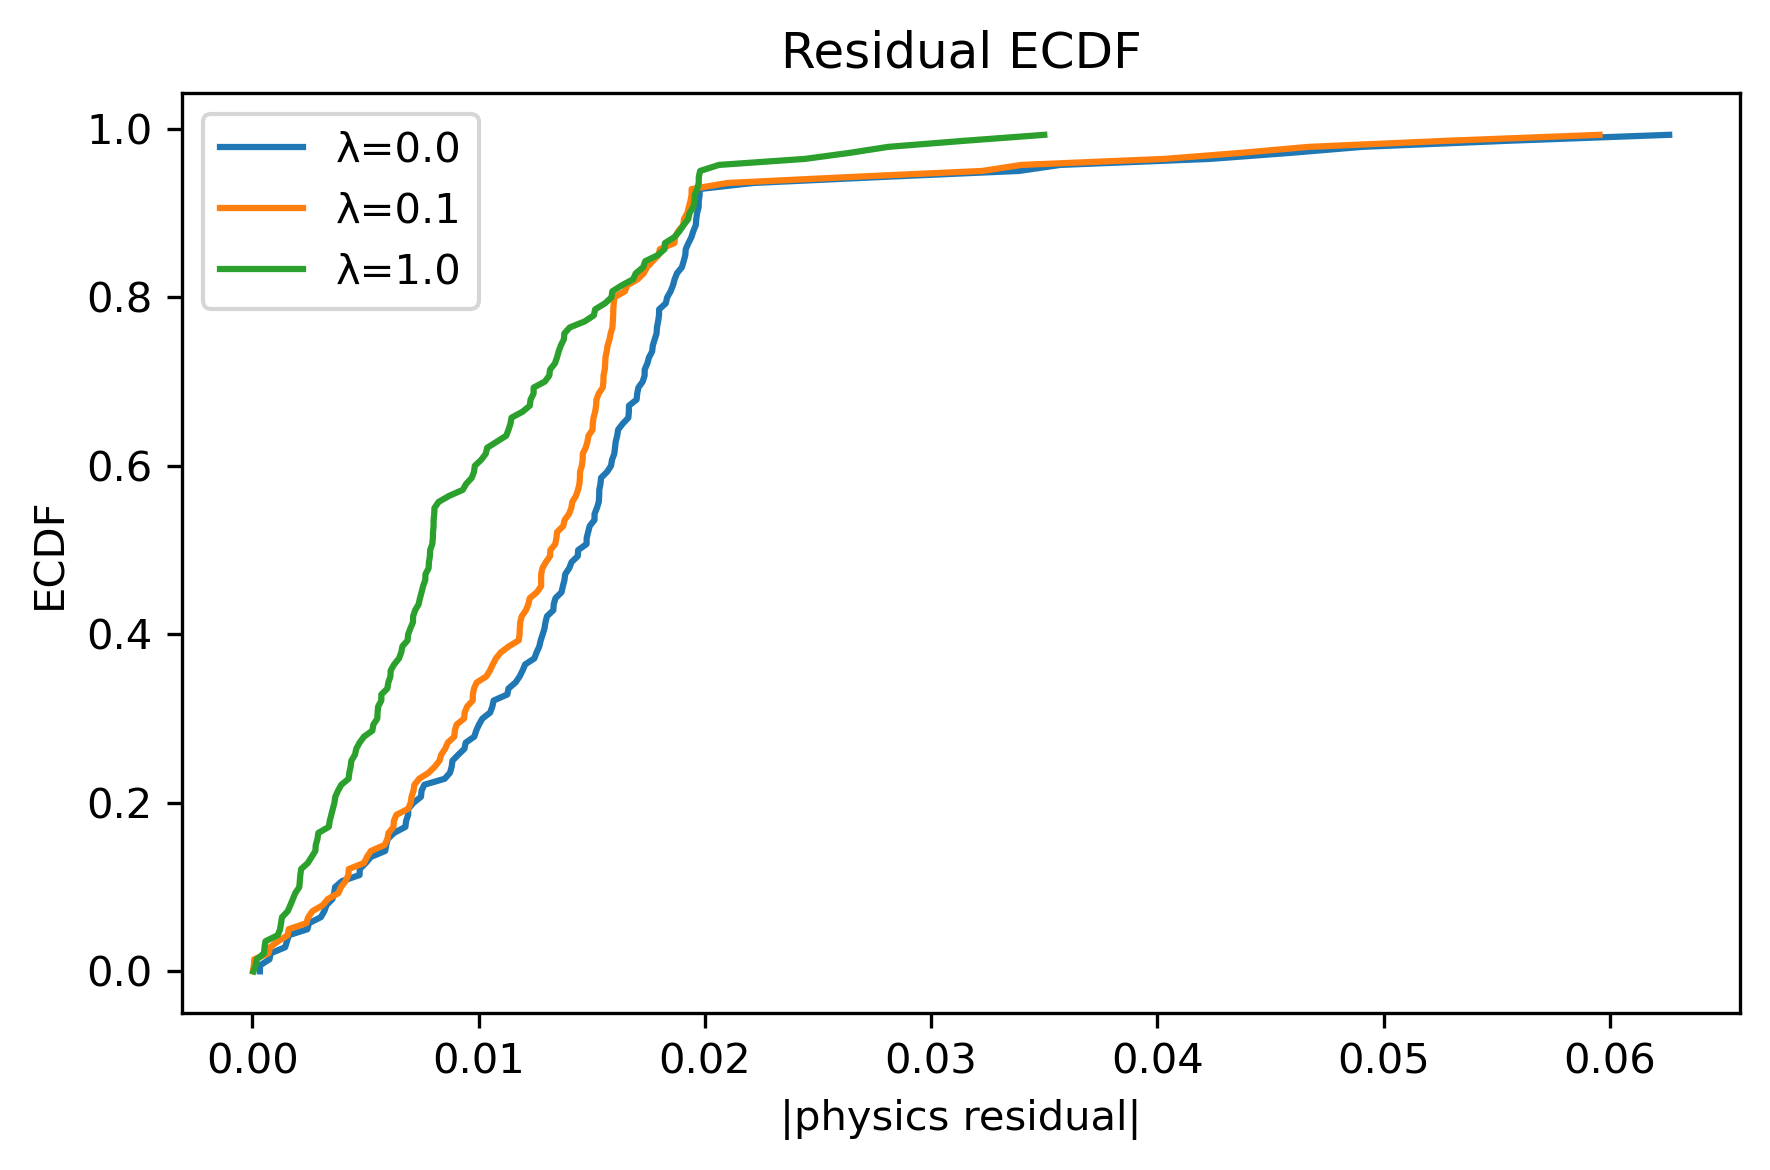

,lam,seed,train_rmse,val_rmse,test_rmse,mean_resid,median_resid,time_sec,epochs
0,0.0,123,0.028350,0.034686,0.022826,0.014359,0.014392,0.283407,80
1,0.1,123,0.028123,0.034834,0.023092,0.013261,0.013166,0.270801,80
2,1.0,123,0.027558,0.034589,0.023397,0.009610,0.007854,0.372602,80


In [4]:


import math, os, json, random, time
from dataclasses import dataclass, asdict
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import json
from matplotlib import rcParams
rcParams["pdf.fonttype"] = 42    # embed TrueType fonts (Illustrator/Word friendly)
rcParams["ps.fonttype"]  = 42
rcParams["figure.dpi"]   = 300   # affects PNGs; fine to keep


import pandas as pd
from IPython.display import display


def set_seed(seed: int = 1337):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def irregular_grid(T=10.0, n=140, seed=0, dt_min=0.03, dt_max=0.12):
    rng = np.random.default_rng(seed)
    dt = rng.uniform(dt_min, dt_max, size=n)
    t = np.cumsum(dt); t = T * t / t[-1]
    return np.unique(t)

def simulate_logistic(t, x0=0.2, r=1.1, K=1.0, noise=0.03, seed=0):
    rng = np.random.default_rng(seed)
    x = np.zeros_like(t, dtype=np.float64); x[0]=x0
    for i in range(1, len(t)):
        dt = t[i] - t[i-1]
        x[i] = x[i-1] + dt * r * x[i-1] * (1 - x[i-1]/K)
        x[i] = np.clip(x[i], 0.0, 1.5*K)
    y = x + noise * rng.standard_normal(len(t))
    return x, y

class TimeMLP(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, t): return self.net(t)

def f_logistic(x, t, r=1.1, K=1.0): return r * x * (1 - x / K)

def physics_residual_ad(model, t, r=1.1, K=1.0):
    # t must already be on the same device & dtype as model
    # e.g., t = t.float().to(device)

    # make t a leaf with grad so we can take d/dt
    t_req = t.clone().detach().requires_grad_(True)

    xhat = model(t_req)
    dxdt = torch.autograd.grad(
        outputs=xhat,
        inputs=t_req,
        grad_outputs=torch.ones_like(xhat),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]

    rhs = r * xhat * (1 - xhat / K)
    return dxdt - rhs, xhat, t_req


@dataclass
class RunResult:
    lam: float; seed: int; train_rmse: float; val_rmse: float; test_rmse: float
    mean_resid: float; median_resid: float; time_sec: float; epochs: int

def split_indices(n, seed=0, frac_train=0.6, frac_val=0.2):
    rng = np.random.default_rng(seed); idx = np.arange(n); rng.shuffle(idx)
    n_train = int(frac_train*n); n_val = int(frac_val*n)
    tr = np.sort(idx[:n_train]); va = np.sort(idx[n_train:n_train+n_val]); te = np.sort(idx[n_train+n_val:])
    return tr, va, te

def rmse(a, b): return float(np.sqrt(np.mean((a-b)**2)))

def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")     # Apple Silicon (Metal)
    elif torch.cuda.is_available():
        return torch.device("cuda")    
    else:
        return torch.device("cpu")     


def train_once(t, y_obs, lam=0.1, weight_decay=5e-5, lr=3e-3, epochs=80, seed=0, r=1.1, K=1.0):
    set_seed(seed)
    n = len(t)
    train_idx, val_idx, test_idx = split_indices(n, seed=seed, frac_train=0.6, frac_val=0.2)

    device = get_device()
    print("Using device:", device)
    

    model = TimeMLP(hidden=32).to(device).float()
    t_t = torch.from_numpy(t.reshape(-1,1))
    y_t = torch.from_numpy(y_obs.reshape(-1,1))

    # Prefer float32 for MPS 
    if device.type == "mps":
        t_t = t_t.float().to(device)
        y_t = y_t.float().to(device)
        model = model.float()
    else:
    
        t_t = t_t.float().to(device)
        y_t = y_t.float().to(device)
        model = model.float()


    
    opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    warm = max(5, epochs//8)

    t0 = time.time()
    for ep in range(epochs):
        model.train(); opt.zero_grad()
        yhat = model(t_t[train_idx])
        data_loss = torch.mean((yhat - y_t[train_idx])**2)
        resid, _, _ = physics_residual_ad(model, t_t[train_idx], r=r, K=K)
        delta = 0.01
        absr = torch.abs(resid)
        phys_loss = torch.where(absr <= delta, 0.5*absr**2, delta*(absr - 0.5*delta)).mean()
        lam_eff = lam * min(1.0, ep / warm)
        loss = data_loss + lam_eff * phys_loss
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()

    train_time = time.time() - t0
    model.eval()

    # yhat_all without grad
    with torch.no_grad():
        yhat_all = model(t_t).cpu().numpy().squeeze()

    # residual with grad enabled (no no_grad here)
    resid_all, _, _ = physics_residual_ad(model, t_t, r=r, K=K)
    resid_np = resid_all.detach().cpu().numpy().squeeze()
    mean_res = float(np.mean(np.abs(resid_np)))
    med_res = float(np.median(np.abs(resid_np)))

    res = RunResult(
        lam=float(lam), seed=seed,
        train_rmse=rmse(yhat_all[train_idx], y_obs[train_idx]),
        val_rmse=rmse(yhat_all[val_idx], y_obs[val_idx]),
        test_rmse=rmse(yhat_all[test_idx], y_obs[test_idx]),
        mean_resid=mean_res, median_resid=med_res,
        time_sec=train_time, epochs=epochs
    )
    return res, yhat_all, resid_np, model

# ---- Run
set_seed(42)
t = irregular_grid(T=10.0, n=140, seed=7)
x_true, y_obs = simulate_logistic(t, x0=0.15, r=1.1, K=1.0, noise=0.03, seed=7)

lams = [0.0, 0.1, 1.0]
results = []; preds_by_lam = {}; resid_by_lam = {}

for lam in lams:
    res, yhat_all, resid_np, model = train_once(t, y_obs, lam=lam, epochs=80, seed=123, r=1.1, K=1.0)
    results.append(res)
    preds_by_lam[lam] = yhat_all
    resid_by_lam[lam] = resid_np

# Save under the current working directory 
out_dir = Path("ode_prior_experiment_fast")
out_dir.mkdir(parents=True, exist_ok=True)

with open(out_dir / "results.json", "w") as f:
    json.dump([asdict(r) for r in results], f, indent=2)

# Plots
plt.figure(figsize=(8,4))
plt.plot(t, x_true, label="true")
plt.scatter(t, y_obs, s=10, label="obs")
for lam in lams:
    plt.plot(t, preds_by_lam[lam], label=f"pred λ={lam}")
plt.xlabel("t"); plt.ylabel("x(t)"); plt.legend(); plt.title("Trajectories")
plt.tight_layout(); plt.show()

# --- Trajectories
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(t, x_true, label="true")
ax.scatter(t, y_obs, s=10, label="obs")
for lam in lams:
    ax.plot(t, preds_by_lam[lam], label=f"pred λ={lam}")
ax.set_xlabel("t"); ax.set_ylabel("x(t)")
ax.legend(); ax.set_title("Trajectories")
fig.tight_layout()
fig.savefig(out_dir / "trajectories.pdf", bbox_inches="tight")   
# fig.savefig(out_dir / "trajectories.png", bbox_inches="tight") 
plt.show()
plt.close(fig)

# --- Fit–Physics Pareto
fig, ax = plt.subplots(figsize=(5,4))
for r in results:
    ax.scatter([r.test_rmse], [r.mean_resid])
    ax.text(r.test_rmse, r.mean_resid, f"λ={r.lam}")
ax.set_xlabel("Test RMSE"); ax.set_ylabel("Mean |residual|")
ax.set_title("Fit–Physics Pareto")
fig.tight_layout()
fig.savefig(out_dir / "pareto.pdf", bbox_inches="tight")
plt.show()
plt.close(fig)

# --- Residual histogram
all_abs_resid = [np.abs(resid_by_lam[lam]) for lam in lams]
bins = np.linspace(0, np.percentile(np.concatenate(all_abs_resid), 99), 40)

fig, ax = plt.subplots(figsize=(6,4))
for lam in lams:
    ax.hist(np.abs(resid_by_lam[lam]), bins=bins, alpha=0.45,
            label=f"λ={lam}", histtype="stepfilled")
ax.set_xlabel("|physics residual|"); ax.set_ylabel("count")
ax.set_title("Residual distribution"); ax.legend()
fig.tight_layout()
fig.savefig(out_dir / "residual_hist.pdf", bbox_inches="tight")
plt.show()
plt.close(fig)

# --- Residual ECDF
fig, ax = plt.subplots(figsize=(6,4))
for lam in lams:
    a = np.sort(np.abs(resid_by_lam[lam]))
    y = np.linspace(0,1,len(a),endpoint=False)
    ax.plot(a, y, label=f"λ={lam}")
ax.set_xlabel("|physics residual|"); ax.set_ylabel("ECDF")
ax.set_title("Residual ECDF"); ax.legend()
fig.tight_layout()
fig.savefig(out_dir / "residual_ecdf.pdf", bbox_inches="tight")
plt.show()
plt.close(fig)



plt.figure(figsize=(5,4))
for r in results:
    plt.scatter([r.test_rmse], [r.mean_resid])
    plt.text(r.test_rmse, r.mean_resid, f"λ={r.lam}")
plt.xlabel("Test RMSE"); plt.ylabel("Mean |residual|"); plt.title("Fit–Physics Pareto")
plt.tight_layout(); plt.show()


all_abs_resid = [np.abs(resid_by_lam[lam]) for lam in lams]
bins = np.linspace(0, np.percentile(np.concatenate(all_abs_resid), 99), 40)

plt.figure(figsize=(6,4))
for lam in lams:
    plt.hist(np.abs(resid_by_lam[lam]), bins=bins, alpha=0.45,
             label=f"λ={lam}", histtype="stepfilled")
plt.xlabel("|physics residual|"); plt.ylabel("count")
plt.title("Residual distribution")
plt.legend()
plt.tight_layout(); plt.show()



plt.figure(figsize=(6,4))
for lam in lams:
    a = np.sort(np.abs(resid_by_lam[lam]))
    y = np.linspace(0,1,len(a),endpoint=False)
    plt.plot(a, y, label=f"λ={lam}")
plt.xlabel("|physics residual|"); plt.ylabel("ECDF")
plt.title("Residual ECDF")
plt.legend(); plt.tight_layout(); plt.show()


# results table
df = pd.DataFrame([asdict(r) for r in results])

# show nicely in Jupyter
display(df)

# also save CSV + JSON for your repo
df.to_csv(out_dir / "results.csv", index=False)
with open(out_dir / "results.json", "w") as f:
    json.dump([asdict(r) for r in results], f, indent=2)

#print(f"Artifacts saved under {out_dir.resolve()}")


[λ=0.00] epoch   1 | r=1.100 K=1.000 | data=0.1576 phys=0.0297
[λ=0.00] epoch  40 | r=1.100 K=1.000 | data=0.0017 phys=0.0253
[λ=0.00] epoch  80 | r=1.100 K=1.000 | data=0.0002 phys=0.0286
[λ=0.00] epoch 120 | r=1.100 K=1.000 | data=0.0000 phys=0.0274
[λ=0.05] epoch   1 | r=1.100 K=1.000 | data=0.1576 phys=0.0297
[λ=0.05] epoch  40 | r=1.092 K=1.000 | data=0.0061 phys=0.0290
[λ=0.05] epoch  80 | r=1.083 K=1.000 | data=0.0038 phys=0.0294
[λ=0.05] epoch 120 | r=1.074 K=1.000 | data=0.0001 phys=0.0257
[λ=0.10] epoch   1 | r=1.100 K=1.000 | data=0.1576 phys=0.0297
[λ=0.10] epoch  40 | r=1.092 K=1.000 | data=0.0007 phys=0.0250
[λ=0.10] epoch  80 | r=1.082 K=1.000 | data=0.0001 phys=0.0236
[λ=0.10] epoch 120 | r=1.074 K=1.000 | data=0.0002 phys=0.0227
[λ=0.20] epoch   1 | r=1.100 K=1.000 | data=0.1576 phys=0.0297
[λ=0.20] epoch  40 | r=1.092 K=1.000 | data=0.0013 phys=0.0200
[λ=0.20] epoch  80 | r=1.082 K=1.000 | data=0.0006 phys=0.0206
[λ=0.20] epoch 120 | r=1.074 K=1.000 | data=0.0006 phys

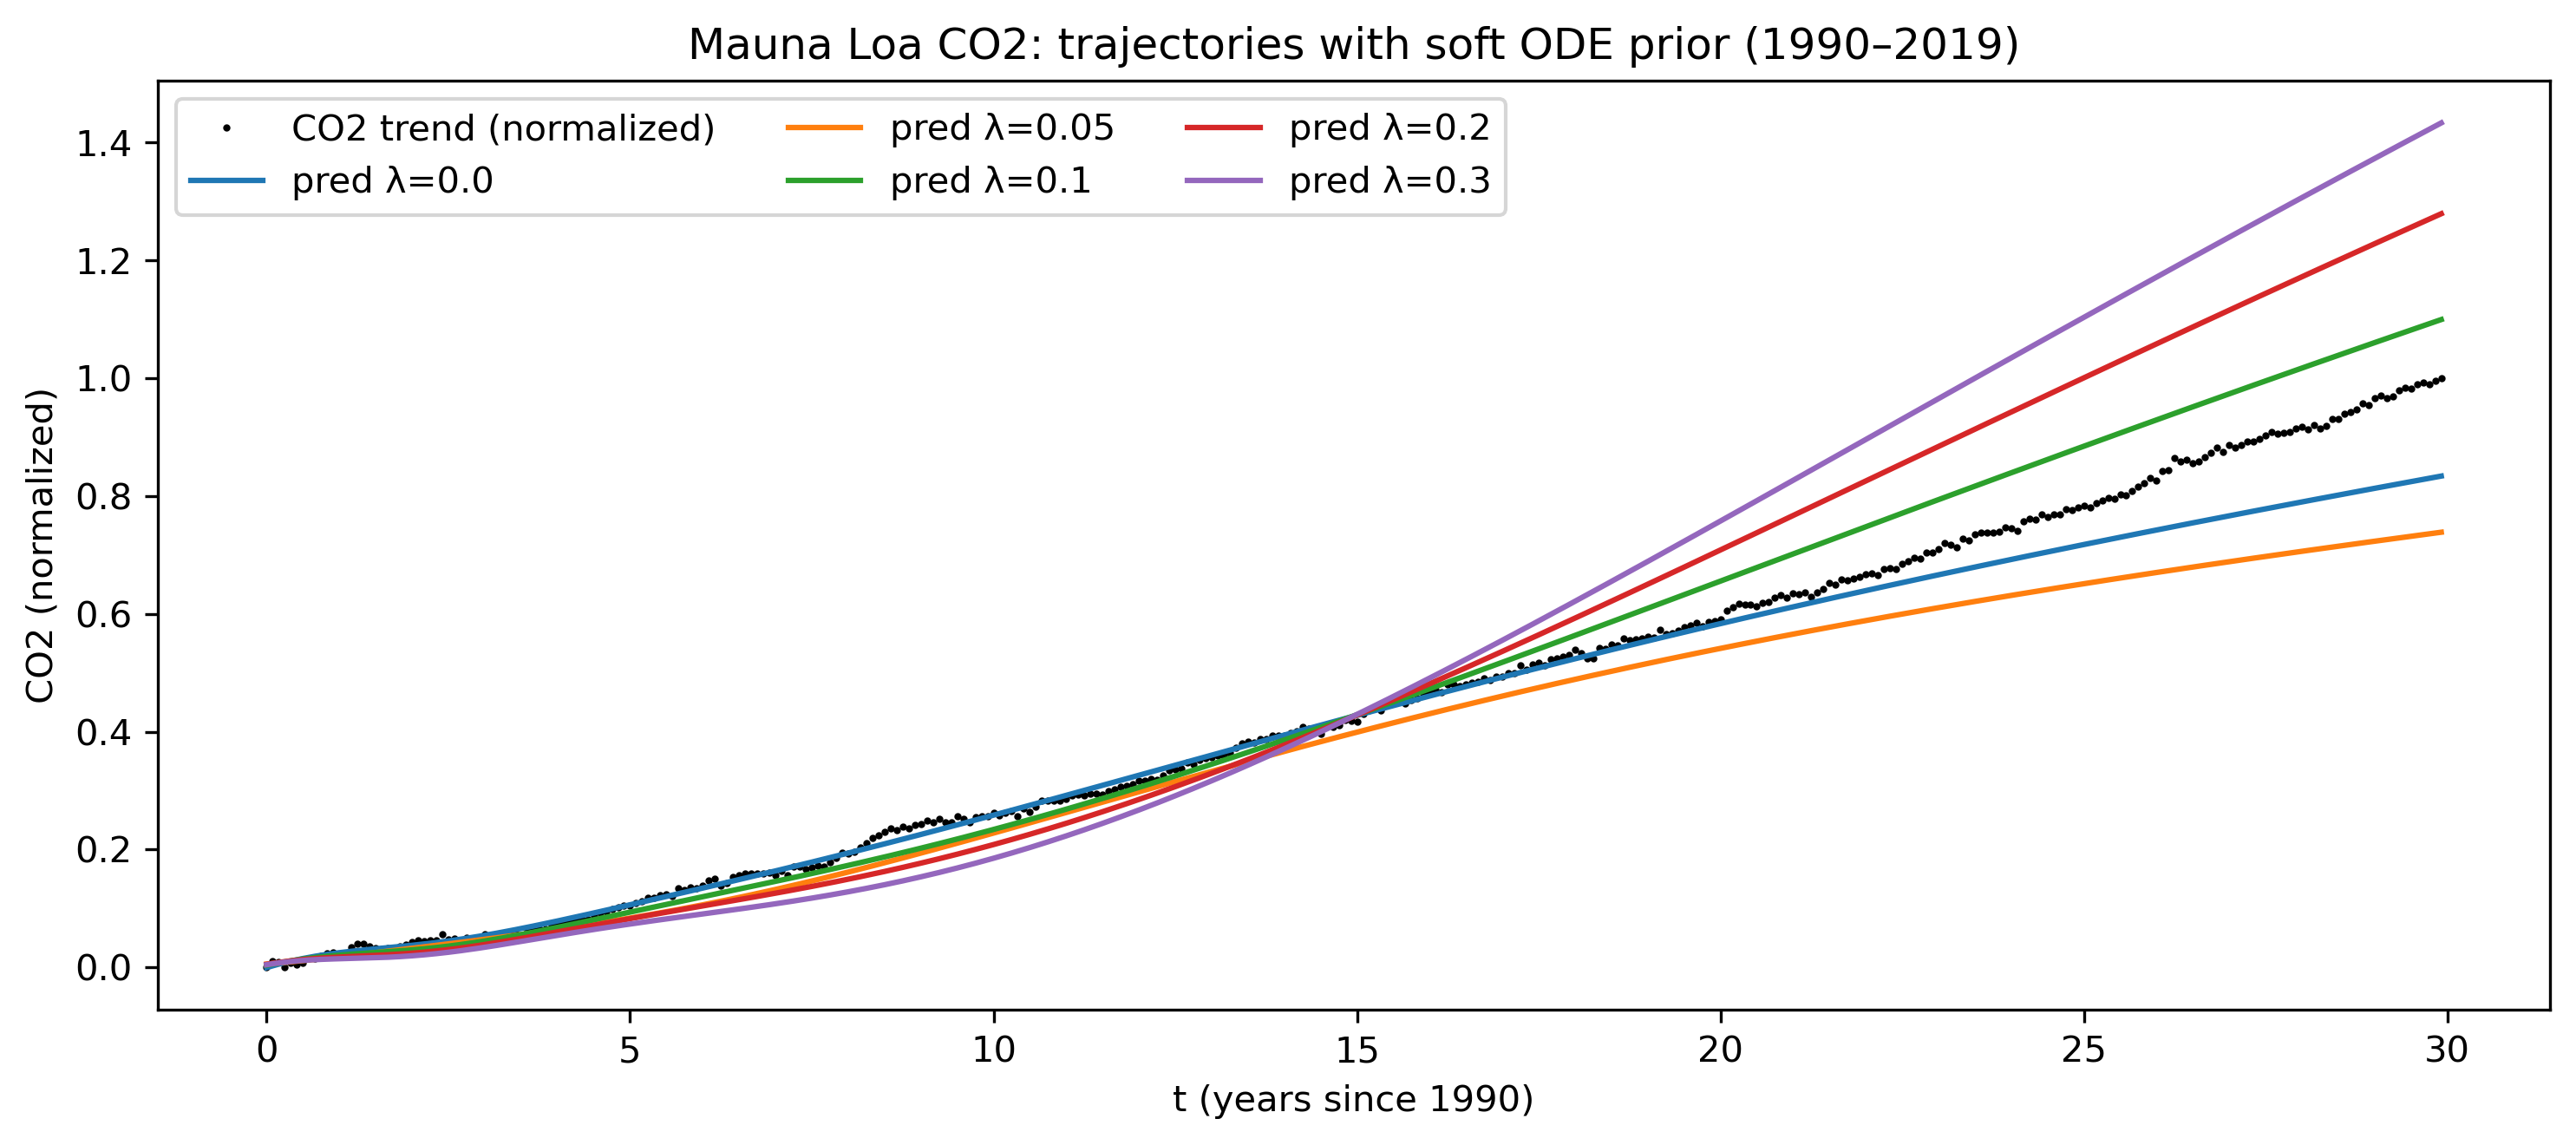

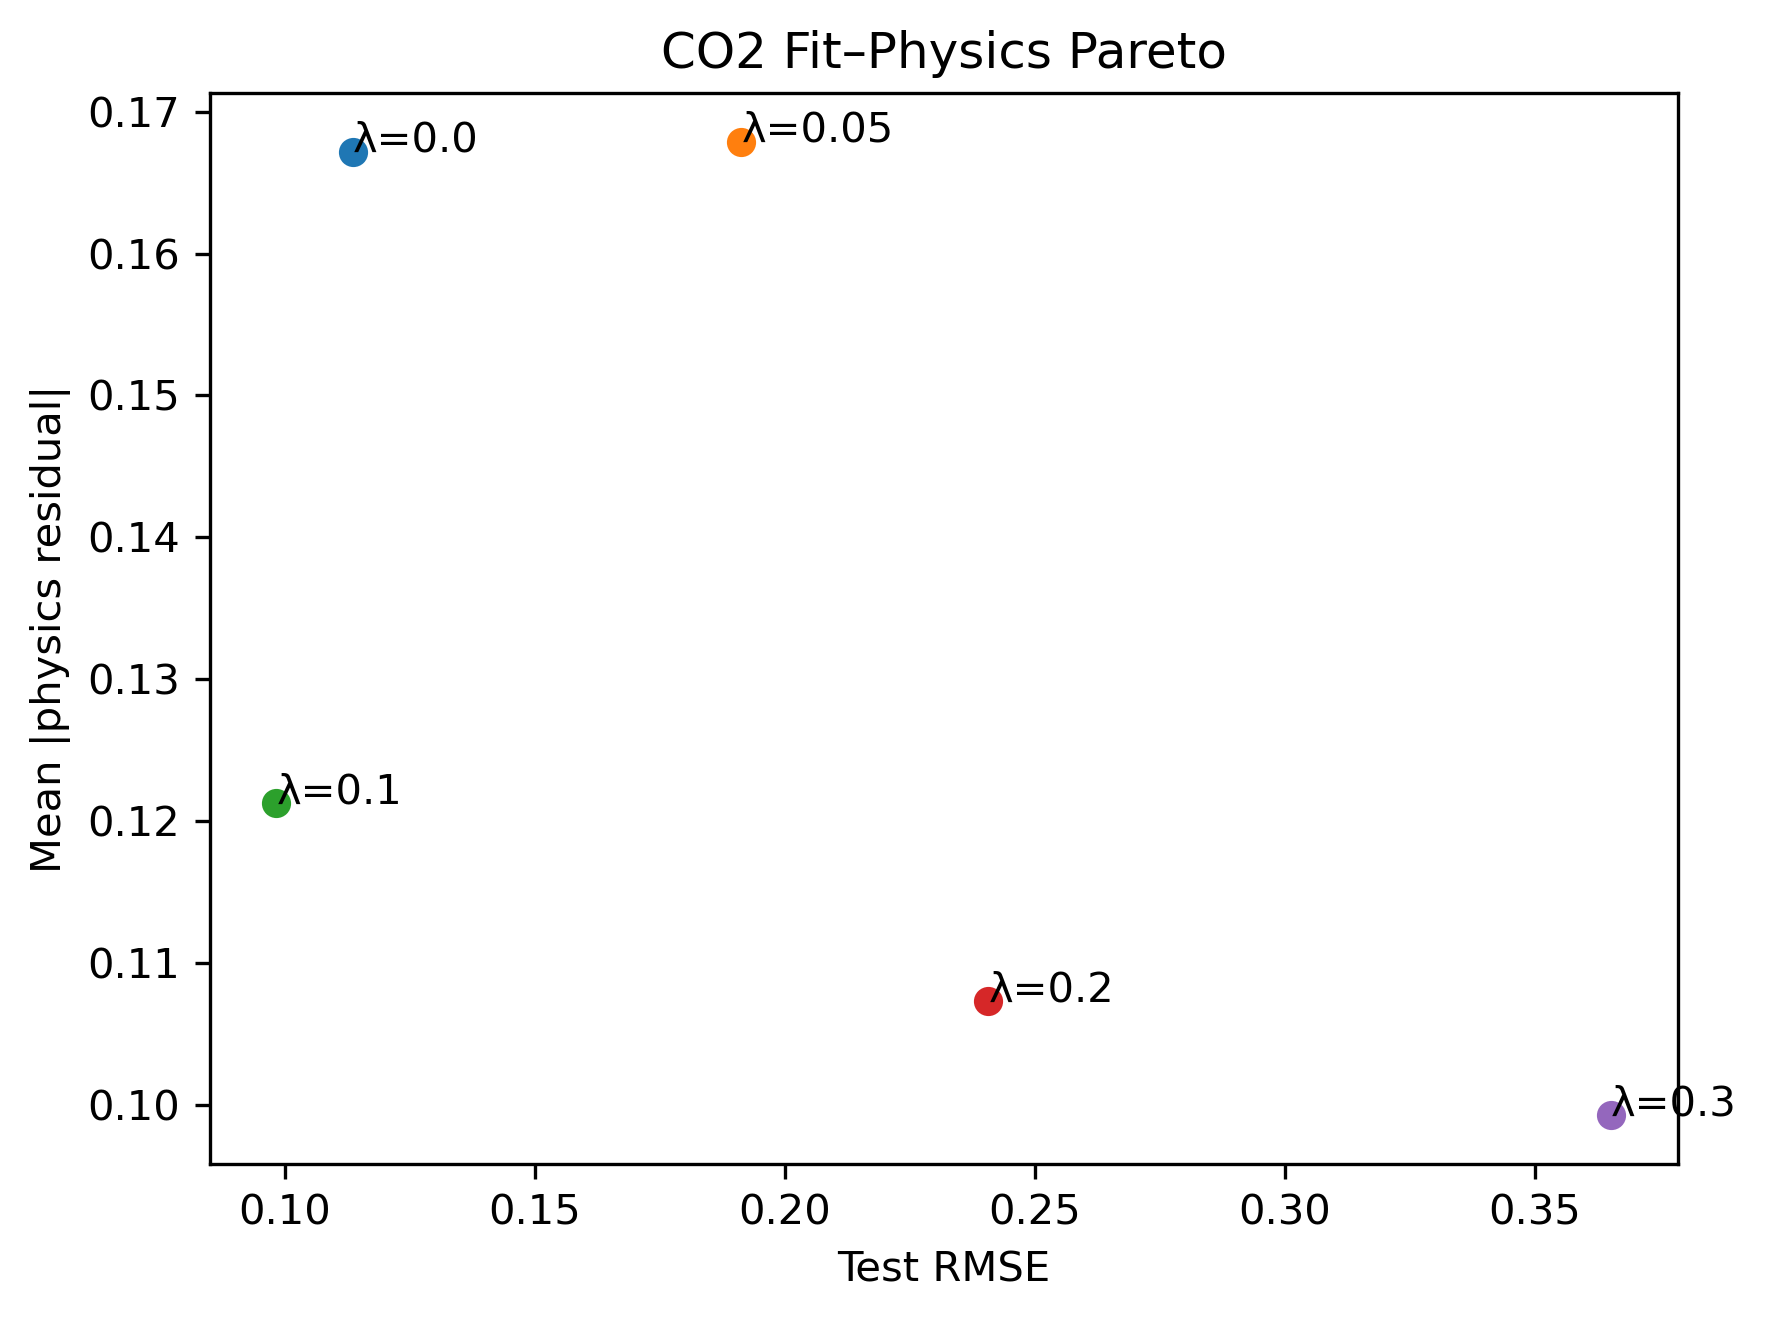

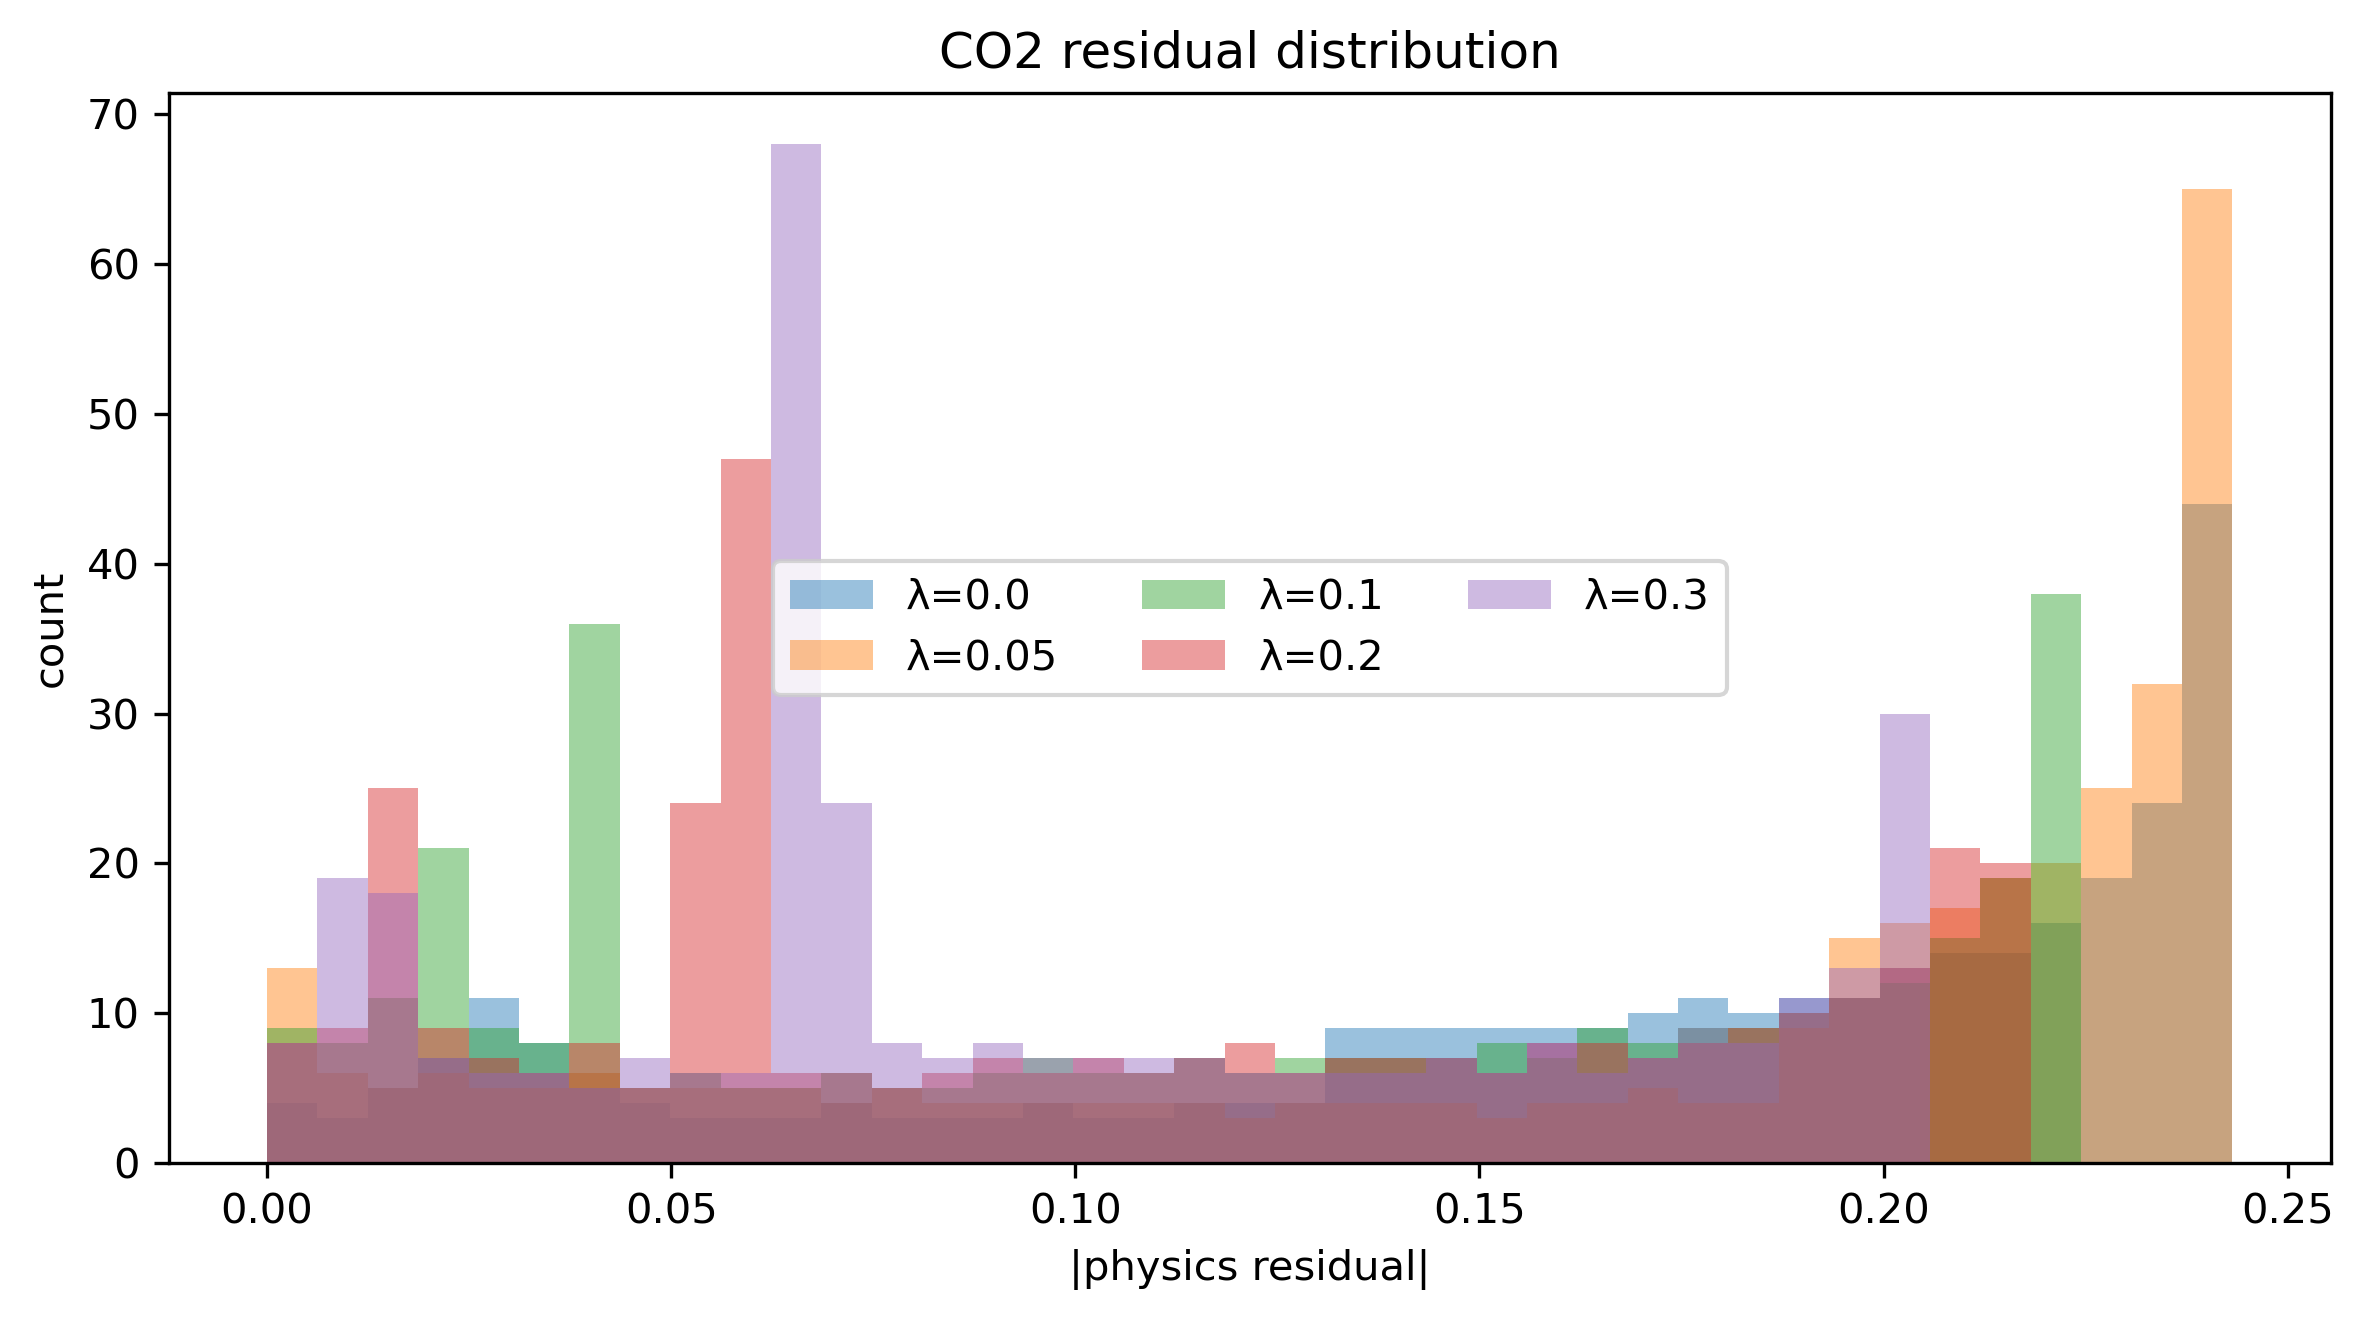

In [29]:
# -----------------------------------------------
# Soft ODE prior for Mauna Loa CO2 with learnable Δr (and optional ΔK)
# -----------------------------------------------
import time
from pathlib import Path
from dataclasses import dataclass, asdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# ----------------- Model & helpers -----------------
class TimeMLP(nn.Module):
    def __init__(self, hid=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hid), nn.SiLU(),
            nn.Linear(hid, hid), nn.SiLU(),
            nn.Linear(hid, 1)
        )
    def forward(self, t):
        return self.net(t)  # [N,1]


def logistic_rhs(x, r, K):
    # x, r, K can be broadcast; assume non-negative r,K
    return r * x * (1.0 - x / K)


def inv_softplus(x):
    # numerically-stable inverse of softplus
    # returns y such that softplus(y) = x
    return torch.log(torch.expm1(x))


@dataclass
class RunResult:
    lam: float
    seed: int
    train_rmse: float
    val_rmse: float
    test_rmse: float
    mean_resid: float
    median_resid: float
    time_sec: float
    epochs: int


def split_indices(N, train=0.6, val=0.2):
    # chronological split (first 60% train, next 20% val, last 20% test)
    n_train = int(N * train)
    n_val   = int(N * val)
    train_idx = np.arange(0, n_train)
    val_idx   = np.arange(n_train, n_train + n_val)
    test_idx  = np.arange(n_train + n_val, N)
    return train_idx, val_idx, test_idx


def train_once_learn_rK(
    t, y_obs, lam, epochs=120, seed=123,
    r0=1.1, K0=1.0,
    learn_r=True, learn_K=False,
    prior_l2=1e-4,   # tiny pull-back on deltas
    sigma_r=0.2,     # trust radii for Δr, ΔK
    sigma_K=0.2,
    lr_model=2e-3, lr_deltas=3e-4, weight_decay=5e-5,
    ramp_lambda=True
):
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available()
                          else "mps" if torch.backends.mps.is_available()
                          else "cpu")

    # tensors
    t_t = torch.as_tensor(t, dtype=torch.float32, device=device).view(-1, 1)
    t_t.requires_grad_(True)
    y_t = torch.as_tensor(y_obs, dtype=torch.float32, device=device).view(-1, 1)

    N = len(t)
    tr_idx, va_idx, te_idx = split_indices(N, train=0.6, val=0.2)

    model = TimeMLP(hid=64).to(device)

    # --- learnable small offsets with exact starting values r0, K0
    base_r = nn.Parameter(inv_softplus(torch.tensor(r0, dtype=torch.float32, device=device)),
                          requires_grad=False)
    base_K = nn.Parameter(inv_softplus(torch.tensor(K0, dtype=torch.float32, device=device)),
                          requires_grad=False)
    delta_r = nn.Parameter(torch.zeros(1, device=device))
    delta_K = nn.Parameter(torch.zeros(1, device=device))

    # optimizer groups
    params = [{"params": model.parameters(), "lr": lr_model, "weight_decay": weight_decay}]
    if learn_r:
        params.append({"params": [delta_r], "lr": lr_deltas, "weight_decay": 0.0})
    if learn_K:
        params.append({"params": [delta_K], "lr": lr_deltas, "weight_decay": 0.0})

    optim_all = optim.AdamW(params)

    huber = nn.HuberLoss(delta=0.1, reduction="mean")  # a bit smoother than 0.01

    t0 = time.time()
    for e in range(epochs):
        optim_all.zero_grad()

        yhat = model(t_t)  # [N,1]

        dydt = torch.autograd.grad(
            yhat, t_t, grad_outputs=torch.ones_like(yhat),
            retain_graph=True, create_graph=True
        )[0]

        # effective positive parameters starting at r0,K0
        r_eff = F.softplus(base_r + (delta_r if learn_r else 0.0))
        K_eff = F.softplus(base_K + (delta_K if learn_K else 0.0))

        # physics on projected state y_phys ∈ [0, K_eff]
        y_phys = torch.clamp(yhat, 0.0, K_eff)
        rhs = logistic_rhs(y_phys, r_eff, K_eff)
        resid = dydt - rhs

        # losses: data on train slice; physics on train slice (or ramp all)
        data_loss = huber(yhat[tr_idx], y_t[tr_idx])

        physics_loss = (resid[tr_idx]**2).mean()  # robust in-data constraint
        if ramp_lambda:
            frac = min(1.0, (e + 1) / max(1, int(epochs * 0.3)))
            lam_use = lam * frac
        else:
            lam_use = lam

        # tiny Gaussian prior on deltas (scaled by trust radii)
        prior = torch.zeros((), device=device)
        if learn_r:
            prior = prior + prior_l2 * (delta_r / sigma_r).pow(2)
        if learn_K:
            prior = prior + prior_l2 * (delta_K / sigma_K).pow(2)

        loss = data_loss + lam_use * physics_loss + prior
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optim_all.step()

        
        if (e + 1) % 40 == 0 or e == 0:
            with torch.no_grad():
                print(f"[λ={lam:.2f}] epoch {e+1:3d} | "
                      f"r={float(r_eff):.3f} K={float(K_eff):.3f} | "
                      f"data={float(data_loss):.4f} phys={float(physics_loss):.4f}")

    # evaluation
    @torch.no_grad()
    def rmse(idxs):
        pred = model(t_t.detach())
        return float(torch.sqrt(torch.mean((pred[idxs] - y_t[idxs])**2)).cpu())

    train_rmse = rmse(tr_idx)
    val_rmse   = rmse(va_idx)
    test_rmse  = rmse(te_idx)

    # physics residuals on the whole window (using same projection)
    model.eval()
    with torch.enable_grad():
        t_eval = t_t.detach().clone().requires_grad_(True)
        yhat_all = model(t_eval)
        dydt_all = torch.autograd.grad(
            yhat_all, t_eval,
            grad_outputs=torch.ones_like(yhat_all),
            retain_graph=False, create_graph=False
        )[0]
        r_eval = F.softplus(base_r + (delta_r if learn_r else 0.0)).detach()
        K_eval = F.softplus(base_K + (delta_K if learn_K else 0.0)).detach()
        y_phys_all = torch.clamp(yhat_all, 0.0, K_eval)
        rhs_all = logistic_rhs(y_phys_all, r_eval, K_eval)
        resid_all = (dydt_all - rhs_all).detach().abs().squeeze().cpu().numpy()

    res = RunResult(
        lam=float(lam), seed=int(seed),
        train_rmse=train_rmse, val_rmse=val_rmse, test_rmse=test_rmse,
        mean_resid=float(np.mean(resid_all)), median_resid=float(np.median(resid_all)),
        time_sec=float(time.time() - t0), epochs=int(epochs),
    )
    # also return the *numbers* of r,K for inspection
    return res, yhat_all.detach().cpu().numpy().squeeze(), resid_all, model, float(r_eval.cpu()), float(K_eval.cpu())


# ----------------- Data & experiment -----------------
out_dir = Path("ode_prior_experiment_fast")
out_dir.mkdir(parents=True, exist_ok=True)

url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv"
co2 = pd.read_csv(
    url, comment="#", header=None,
    names=["year","month","decimal_date","average","deseasonalized","ndays","sdev","unc"],
    skip_blank_lines=True
)
# clean
for c in ["year","month","decimal_date","average","deseasonalized","ndays","sdev","unc"]:
    co2[c] = pd.to_numeric(co2[c], errors="coerce")
co2["average"] = co2["average"].replace(-99.99, np.nan)
co2["deseasonalized"] = co2["deseasonalized"].replace(-99.99, np.nan)
co2["ndays"] = co2["ndays"].replace(-1, np.nan)
co2 = co2.dropna(subset=["deseasonalized"]).copy()
co2["date"] = pd.to_datetime(dict(year=co2["year"].astype(int),
                                  month=co2["month"].astype(int), day=1))
co2 = co2.sort_values("date").reset_index(drop=True)

# window
mask = (co2["date"] >= "1990-01-01") & (co2["date"] < "2020-01-01")
co2_win = co2.loc[mask].copy()

# time: natural years since window start
t_years = co2_win["decimal_date"].to_numpy()
t = t_years - t_years[0]  # 0 … ~30 years

# target: normalized deseasonalized trend to [0,1]
y_raw = co2_win["deseasonalized"].to_numpy().astype(float)
y_min, y_max = np.nanmin(y_raw), np.nanmax(y_raw)
y_obs = (y_raw - y_min) / (y_max - y_min + 1e-8)

# physics priors (on normalized state)
r0 = 1.1    # per year
K0 = 1.0    # normalized carrying capacity

# sweep
lams = [0.0, 0.05, 0.1, 0.2, 0.3]  
EPOCHS = 120

results = []
preds_by_lam = {}
resid_by_lam = {}
rK_by_lam = {}

for lam in lams:
    res, yhat_all, resid_np, _, r_eff_num, K_eff_num = train_once_learn_rK(
        t=t, y_obs=y_obs, lam=lam, epochs=EPOCHS, seed=123,
        r0=r0, K0=K0,
        learn_r=True, learn_K=False,         
        prior_l2=1e-4, sigma_r=0.2, sigma_K=0.2,
        lr_model=2e-3, lr_deltas=3e-4, weight_decay=5e-5,
        ramp_lambda=True
    )
    res.lam = lam
    results.append(res)
    preds_by_lam[lam] = yhat_all
    resid_by_lam[lam] = resid_np
    rK_by_lam[lam] = (r_eff_num, K_eff_num)

# results table
import pandas as pd
df = pd.DataFrame([asdict(r) for r in results]).sort_values("lam")
print(df.round(6))
for lam in lams:
    r_eff_num, K_eff_num = rK_by_lam[lam]
    print(f"λ={lam:.2f} → learned r={r_eff_num:.4f}, K={K_eff_num:.4f}")

# normalized residual (scale-aware)
dy_dt = np.gradient(y_obs, t)
mean_abs_dydt = float(np.mean(np.abs(dy_dt)) + 1e-8)
norm_resid = {lam: float(np.mean(np.abs(resid_by_lam[lam])) / mean_abs_dydt)
              for lam in sorted(resid_by_lam)}
print("Normalized mean residual:", {k: round(v, 4) for k, v in norm_resid.items()})

# ----------------- Plots -----------------
start_year = int(co2_win["year"].iloc[0])

# trajectories
plt.figure(figsize=(10,4.5))
plt.plot(t, y_obs, "k.", ms=2, label="CO2 trend (normalized)")
for lam in lams:
    plt.plot(t, preds_by_lam[lam], label=f"pred λ={lam}")
plt.xlabel(f"t (years since {start_year})")
plt.ylabel("CO2 (normalized)")
plt.title(f"Mauna Loa CO2: trajectories with soft ODE prior ({start_year}–2019)")
plt.legend(ncol=3)
plt.tight_layout()
plt.savefig(out_dir / "co2_trajectories_soft_ode_prior.png", dpi=180)
plt.show()

# Pareto
plt.figure(figsize=(6,4.5))
for r in results:
    plt.scatter([r.test_rmse], [r.mean_resid])
    plt.text(r.test_rmse, r.mean_resid, f"λ={r.lam}")
plt.xlabel("Test RMSE")
plt.ylabel("Mean |physics residual|")
plt.title("CO2 Fit–Physics Pareto")
plt.tight_layout()
plt.savefig(out_dir / "co2_fit_physics_pareto.png", dpi=180)
plt.show()

# Residual histogram
all_abs_resid = [np.abs(resid_by_lam[lam]) for lam in lams]
bins = np.linspace(0, np.percentile(np.concatenate(all_abs_resid), 99), 40)
plt.figure(figsize=(8,4.5))
for lam in lams:
    plt.hist(np.abs(resid_by_lam[lam]), bins=bins, alpha=0.45,
             label=f"λ={lam}", histtype="stepfilled")
plt.xlabel("|physics residual|")
plt.ylabel("count")
plt.title("CO2 residual distribution")
plt.legend(ncol=3)
plt.tight_layout()
plt.savefig(out_dir / "co2_residual_distribution.png", dpi=180)
plt.show()
